In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans


In [5]:
df = pd.read_csv('../Startup_Scoring_Dataset.csv')  # Data Loading...
df.head(5)

,startup_id,team_experience,market_size_million_usd,monthly_active_users,monthly_burn_rate_inr,funds_raised_inr,valuation_inr
0,S001,7,789,66299,6091495,4183839,263247468
1,S002,4,939,34866,9106842,666326,172927107
2,S003,8,42,73630,8817088,649150,313090455
3,S004,5,57,93657,6374167,20153173,305887183
4,S005,7,512,61187,841971,118834,84815222


In [6]:
df.isnull().sum()                                             # Check for Null value

startup_id                 0
team_experience            0
market_size_million_usd    0
monthly_active_users       0
monthly_burn_rate_inr      0
funds_raised_inr           0
valuation_inr              0
dtype: int64

In [7]:
df.duplicated().sum()                                          # Check Duplicate Value

0

In [8]:
df['market_size_inr'] = df['market_size_million_usd'] * 1e6 * 83                       # convert market size USd to INR
df.drop(columns=['market_size_million_usd'], inplace=True)

columns_to_normalize = [                                                               # Normalize relevant columns
    'team_experience',
    'monthly_active_users',
    'market_size_inr',
    'monthly_burn_rate_inr',
    'funds_raised_inr',
    'valuation_inr'
]

scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df[columns_to_normalize]), columns=columns_to_normalize)         # normalized values

df_norm['monthly_burn_rate_inr'] = 1 - df_norm['monthly_burn_rate_inr']                                      #  Invert monthly burn rate 
df_norm.head()

,team_experience,monthly_active_users,market_size_inr,monthly_burn_rate_inr,funds_raised_inr,valuation_inr
0,0.666667,0.669162,0.789206,0.393230,0.082061,0.518992
1,0.333333,0.347274,0.941955,0.084439,0.011052,0.333843
2,0.777778,0.744235,0.028513,0.114112,0.010706,0.621166
3,0.444444,0.949320,0.043788,0.364283,0.404435,0.606400
4,0.666667,0.616813,0.507128,0.930815,0.000000,0.153220


## Assign Weight

In [9]:
weights = {                                                                                          # Assign weighted
    'team_experience': 0.15,
    'monthly_active_users': 0.25,
    'market_size_inr': 0.20,
    'monthly_burn_rate_inr': 0.10,
    'funds_raised_inr': 0.15,
    'valuation_inr': 0.15
}

df_norm['final_score'] = sum(df_norm[col] * weight for col, weight in weights.items())

df['final_score'] = (df_norm['final_score'] * 100).round(2)
print(df.head(5))

  startup_id  team_experience  monthly_active_users  monthly_burn_rate_inr  \
0       S001                7                 66299                6091495   
1       S002                4                 34866                9106842   
2       S003                8                 73630                8817088   
3       S004                5                 93657                6374167   
4       S005                7                 61187                 841971   

   funds_raised_inr  valuation_inr  market_size_inr  final_score  
0           4183839      263247468     6.548700e+10        55.46  
1            666326      172927107     7.793700e+10        38.54  
2            649150      313090455     3.486000e+09        41.46  
3          20153173      305887183     4.731000e+09        50.08  
4            118834       84815222     4.249600e+10        47.17  


## Applied KMeans clustering to group startups into clusters based on their normalized features


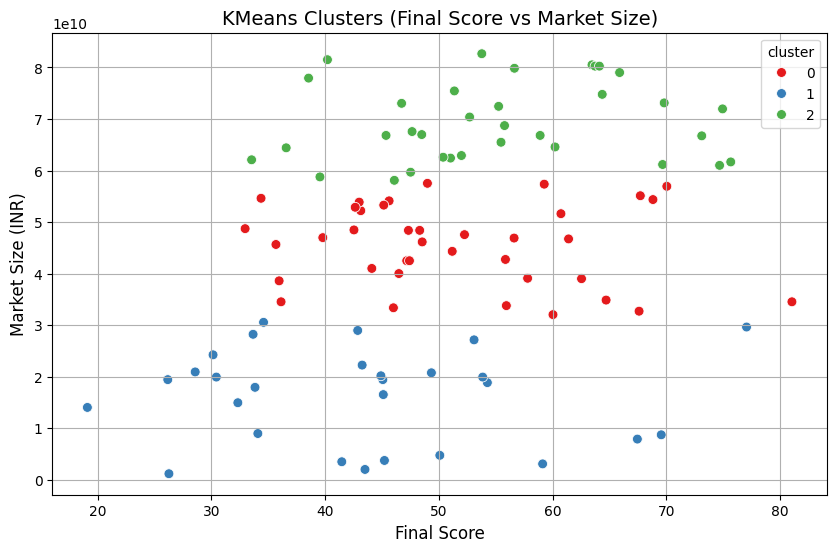

In [36]:
X = df[['final_score', 'market_size_inr']]                                
kmeans = KMeans(n_clusters=3, random_state=42)                              #  applied KMeans clustering to group startups into clusters 
df['cluster'] = kmeans.fit_predict(X)

plt.figure(figsize=(10, 6))                                                 # Visualize Cluster
sns.scatterplot(data=df, x='final_score', y='market_size_inr', hue='cluster', palette='Set1', s=50)
plt.title('KMeans Clusters (Final Score vs Market Size)', fontsize=14)
plt.xlabel('Final Score', fontsize=12)
plt.ylabel('Market Size (INR)', fontsize=12)
plt.grid(True)
plt.savefig("../Outputs/startup_Clusterchart", dpi=150, bbox_inches='tight')
plt.show()


## Top 10 Startups

In [13]:
df_sorted = df.sort_values(by='final_score', ascending=False).reset_index(drop=True)

top_10 = df_sorted.head(10)                                                                              # Top 10 startups
print("\nTop 10 Startups:\n", top_10[['startup_id', 'final_score']])


Top 10 Startups:
   startup_id  final_score
0       S006        81.04
1       S077        77.05
2       S045        75.66
3       S033        74.94
4       S013        74.68
5       S029        73.11
6       S097        70.04
7       S012        69.81
8       S008        69.67
9       S043        69.55


## Bottom 10 Startups

In [14]:
Bottom_10 = df_sorted.tail(10)                                                                          # Bottom 10 Startups
print("\nBottom 10 Startups:\n", Bottom_10[['startup_id', 'final_score']])


Bottom 10 Startups:
    startup_id  final_score
90       S074        33.66
91       S017        33.53
92       S061        32.96
93       S051        32.32
94       S079        30.43
95       S084        30.14
96       S058        28.57
97       S023        26.26
98       S098        26.16
99       S055        19.09


## Histogram of score distribution

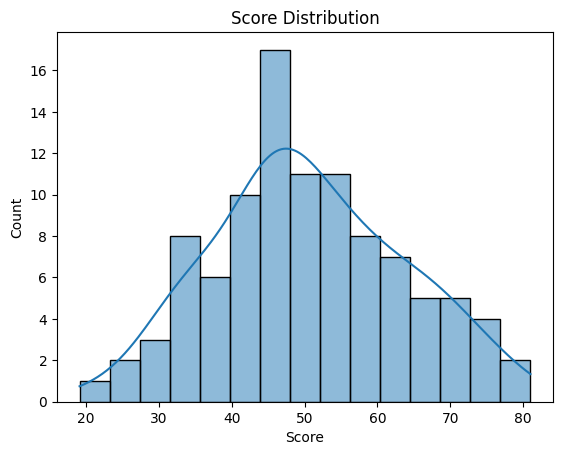

In [32]:
# plt.figure(figsize=(6, 4))                                                                   
sns.histplot(df['final_score'], kde=True, bins=15)
plt.title("Score Distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.savefig("../Outputs/score_distribution_hist.png", dpi=150, bbox_inches='tight')
plt.show()

## Correlation heatmap

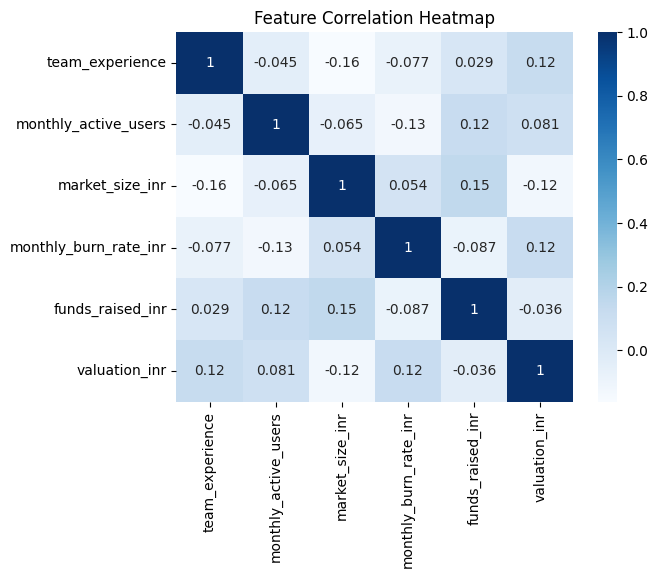

In [31]:
# plt.figure(figsize=(8, 6))                                                                      
sns.heatmap(df[columns_to_normalize].corr(), annot=True, cmap='Blues')
plt.title("Feature Correlation Heatmap")
plt.savefig("../Outputs/correlation_heatmap.png", dpi=150, bbox_inches='tight')
plt.show()

## Bar chart of all scores

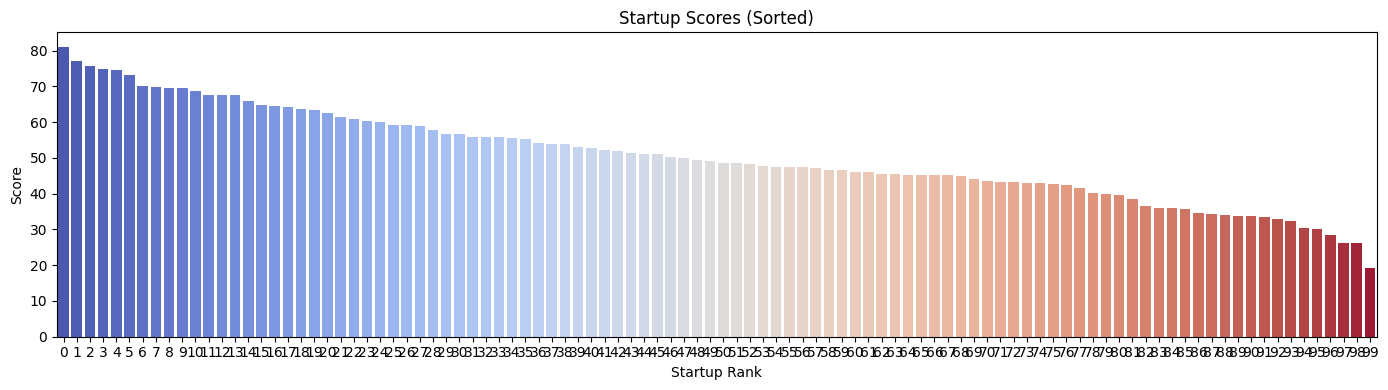

In [33]:
df_sorted['startup_rank'] = df_sorted.index                                                
plt.figure(figsize=(14, 4))
sns.barplot(x=df_sorted.index, y='final_score',hue='startup_rank', data=df_sorted, palette='coolwarm',legend=False)
plt.title("Startup Scores (Sorted)")
plt.xlabel("Startup Rank")
plt.ylabel("Score")
plt.tight_layout()
plt.savefig("../outputs/startup_scores_barplot.png", dpi=150, bbox_inches='tight')
plt.show()

## RMSE evaluation

### We trained a Linear Regression model using the same normalized features used to manually compute the final_score. Since finalscore was created as a weighted sum of those features, the model is able tolearn the relationship almost perfectly.

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

# Features and target
X = df_norm[[
    'team_experience',
    'market_size_inr',
    'monthly_active_users',
    'monthly_burn_rate_inr',
    'funds_raised_inr',
    'valuation_inr'
]]
y = df_norm['final_score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", round(rmse, 4))


RMSE: 0.0


## Feature Importance Bar Chart

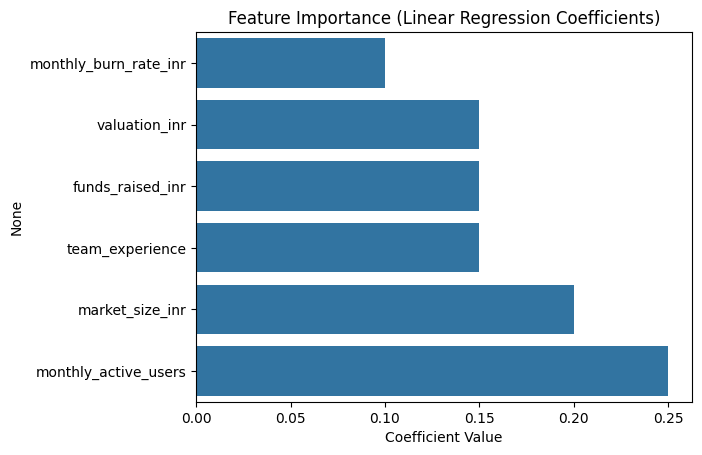

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

coeffs = pd.Series(model.coef_, index=X.columns).sort_values()
sns.barplot(x=coeffs.values, y=coeffs.index)
plt.title("Feature Importance (Linear Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.savefig("../outputs/feature_importance_plot.png", dpi=150, bbox_inches='tight')
plt.show()